In [5]:
import cv2
import numpy as np
import os

In [6]:
dsPath = "./hand_washing_ds/HandWashDataset/"

In [7]:
classFolderMap = {
    0 : 'Step_1',
    1 : 'Step_2_Left',
    2 : 'Step_2_Right',
    3 : 'Step_3',
    4 : 'Step_4_Left',
    5 : 'Step_4_Right',
    6 : 'Step_5_Left',
    7 :'Step_5_Right',
    8 : 'Step_6_Left',
    9 :'Step_6_Right',
    10 : 'Step_7_Left',
    11 : 'Step_7_Right',
}

In [8]:
img_rows,img_cols,img_depth = 150,100,20

In [12]:
def read_data():
    x_set = []
    y_labels = []

    for key, val in classFolderMap.items():
        videosInFolder = os.listdir(dsPath+val)
        for vid in videosInFolder:
            cap = cv2.VideoCapture(dsPath + val + "/" + vid)
            # fps = cap.get(5)
            # print(fps)
            enoughFrames = True

            while True:

                frames = []
                for k in range(img_depth):
                    ret, frame = cap.read()
                    if not ret:
    #                     print("Not enough frames in ", vid)
                        enoughFrames = False
                        break
                    frame = cv2.resize(frame,
                         (img_rows, img_cols), interpolation= cv2.INTER_AREA)
                    grayFrame = cv2.cvtColor(frame, cv2.COLOR_BGR2GRAY)
                    frames.append(grayFrame)

                if not enoughFrames:
                    break
                inputs = np.array(frames)
                ipt = np.rollaxis(np.rollaxis(inputs,2,0),2,0)
                x_set.append(ipt)
                y_labels.append(key)

            cap.release()
        print(len(y_labels))
        print(val + ", done")
    return np.array(x_set), np.array(y_labels)

In [13]:
x_data, y_data = read_data()

574
Step_1, done
1052
Step_2_Left, done
1525
Step_2_Right, done
1998
Step_3, done
2536
Step_4_Left, done
3016
Step_4_Right, done
3515
Step_5_Left, done
3995
Step_5_Right, done
4446
Step_6_Left, done
4856
Step_6_Right, done
5265
Step_7_Left, done
5664
Step_7_Right, done


In [24]:
from utils import displayPlt

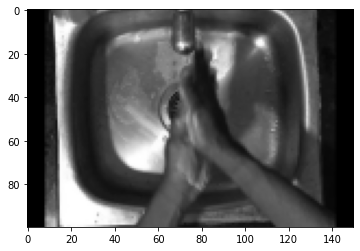

In [25]:
displayPlt(x_set[3][:,:,0])

In [16]:
numOfSamples = len(x_data)

In [17]:
from sklearn.model_selection import train_test_split

In [20]:
dataSplitRatio = 0.2
validationtRatio = 0.2

x_train, x_test, y_train, y_test = train_test_split(x_data,
										y_data, test_size=dataSplitRatio)

x_train, x_valid, y_train, y_valid = train_test_split(x_train,
										y_train, test_size=validationtRatio)



In [19]:
# x_train = x_train.astype('float32')
# x_train -= np.mean(x_train)
# x_train /= np.max(x_train)

# x_test = x_test.astype('float32')
# x_test -= np.mean(x_test)
# x_test /= np.max(x_test)

# x_valid = x_valid.astype('float32')
# x_valid -= np.mean(x_valid)
# x_valid /= np.max(x_valid)

KeyboardInterrupt: 

In [ ]:
train_set = np.zeros((numOfSamples, img_rows, img_cols, img_depth, 1))

In [ ]:
for h in range(numOfSamples):
    train_set[h,:,:,:,0]=x_data[h,:,:,:]

In [ ]:
patch_size = img_depth 

In [ ]:
batch_size = 4
nb_classes = 12
nb_epoch = 50

In [ ]:
from keras.utils import np_utils

In [ ]:
y_train = np_utils.to_categorical(y_data, nb_classes)

In [ ]:
nb_filters = [  32,   # 1st conv layer
                32    # 2nd
             ]

In [ ]:
from keras.preprocessing.image import ImageDataGenerator
from keras.models import Sequential, load_model
from keras.layers.core import Dense, Dropout, Activation, Flatten
from keras.layers.convolutional import Conv3D, MaxPooling3D
from keras.layers import BatchNormalization
from keras.optimizers import SGD, RMSprop
from keras.utils import np_utils
from keras.callbacks import TensorBoard

In [ ]:
RMSprob = RMSprop(learning_rate=0.001, rho=0.9, epsilon=None, decay=0.0)

# Models building Basic

In [ ]:
from sklearn.model_selection import train_test_split
from sklearn import preprocessing
import tensorflow as tf
import datetime
import pdb

In [ ]:
model = Sequential()
print('input shape', img_rows, 'rows', img_cols, 'cols', patch_size, 'patchsize')

model.add(Conv3D(nb_filters[0],(5,5,5),input_shape=(img_rows, img_cols,patch_size,1),activation='relu'))
model.add(MaxPooling3D(pool_size=(3, 3, 3)))
model.add(BatchNormalization(momentum=0.99))

model.add(Conv3D(nb_filters[1],(3,3,3),activation='relu'))
model.add(MaxPooling3D(pool_size=(3, 3, 3)))

model.add(Dropout(0.5))
model.add(Flatten())
model.add(Dense(256))
model.add(Dropout(0.5))

model.add(Dense(nb_classes))

model.add(Activation('softmax'))
model.compile(loss='categorical_crossentropy', optimizer='RMSprop', metrics=['mse', 'accuracy'])


In [ ]:
model.summary()

In [ ]:
X_train_new, X_val_new, y_train_new,y_val_new = train_test_split(train_set, y_train,
                                                                 test_size=0.2, random_state=4)

In [ ]:
hist = model.fit(X_train_new,
			    y_train_new,
			    validation_data=(X_val_new,y_val_new),
			    batch_size=batch_size,
			    epochs = nb_epoch,
			    shuffle=True,
			    callbacks=[TensorBoard(log_dir='./log')] )#tensorboard --logdir=./log

In [ ]:
now = str(datetime.datetime.now()).split('.')[0]
model.save('./models/'+now+"-model.h5")

In [ ]:
score = model.evaluate(X_val_new,y_val_new,batch_size=batch_size)
# Print the results
print('**********************************************')
print('Test score:', score)
print('History', hist.history)

In [ ]:
import matplotlib.pyplot as plt
plt.figure(1)
plt.plot(hist.history['loss'])
plt.plot(hist.history['val_loss'])
plt.legend(['training', 'validation'])
plt.title("Loss")
plt.xlabel("Epoch")

plt.figure(2)
plt.plot(hist.history['accuracy'])
plt.plot(hist.history['val_accuracy'])
plt.legend(['training', 'validation'])
plt.title("Accuracy")
plt.xlabel("Epoch")

plt.show()


In [ ]:
import sys,pdb,natsort

In [ ]:
files = os.listdir('./test/')

In [ ]:
nb_files = len(files)


In [ ]:
print('number of files:%s'%(nb_files))
files = natsort.natsorted(files)

In [ ]:
lets_test_for = []

In [ ]:
for f in files: 
    frames = []
    path = './test/'+f
    cap = cv2.VideoCapture(path)
    fps = cap.get(5)
    img_rows,img_cols,img_depth=32,32,15
    for k in range(15):
        ret, frame = cap.read()
        frame=cv2.resize(frame,(img_rows,img_cols),interpolation=cv2.INTER_AREA)
        gray = cv2.cvtColor(frame, cv2.COLOR_BGR2GRAY)
        frames.append(gray)
        if cv2.waitKey(1) & 0xFF == ord('q'):
            break
    cap.release()
    cv2.destroyAllWindows()
    inputs=np.array(frames)
    ipt=np.rollaxis(np.rollaxis(inputs,2,0),2,0)
    lets_test_for.append(ipt)

lets_test_for = np.array(lets_test_for)

In [ ]:
test_set = np.zeros((nb_files, img_rows, img_cols, img_depth, 1))

In [ ]:
for i in range(nb_files):
	test_set[i,:,:,:,0]=lets_test_for[i,:,:,:]

In [ ]:
test_set = test_set.astype('float32')
test_set -= np.mean(test_set)
test_set /= np.max(test_set)

In [ ]:
results = []#predict results

In [ ]:
y = model.predict(test_set)

In [ ]:
for j in range(nb_files):
    index = np.argmax(y[j])
    action = classFolderMap[index]
    results.append(action)
print("File names | Predict labels")


for pair in zip(files,results):
    print(pair)